In [4]:
import os

download_name = "surnames_with_splits.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "surnames_with_splits.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))       

# Surname Classification 

In this example, we see surname classification. 

This is a modified version of the main example in which we use the PackedSequences data structure that PyTorch provides.  While PackedSequences is a useful data structure, seeing what's happening with column indexing is very useful. 

In [5]:
import os
import re

import requests
import gzip
import torch
import torch.nn.functional as F

from argparse import Namespace
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings

In [6]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    model_filename="model.pth",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stop=10,
    # Runtime hyper parameter
)

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading

In [7]:
df = pd.read_csv(args.surname_csv)
df

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh
...,...,...,...,...
10975,Vietnamese,11,test,Dinh
10976,Vietnamese,11,test,Phung
10977,Vietnamese,11,test,Quang
10978,Vietnamese,11,test,Vu


## Vocabulary, Vectorizer, Dataset

In [8]:
class Vocab(object):

    def __init__(self, tokens=None, pad_token=None, unk_token=None, begin_seq_token=None, end_seq_token=None):
        self._tok2idx = {}
        self._idx2tok = {}
        
        self.pad_token = pad_token
        self.pad_idx = None
        if pad_token is not None:
            self.pad_idx = self.add_token(pad_token)
        
        self.unk_token = unk_token
        self.unk_idx = None
        if unk_token is not None:
            self.unk_idx = self.add_token(unk_token)

        self.begin_seq_token = begin_seq_token
        self.begin_seq_idx = None
        if begin_seq_token is not None:
            self.begin_seq_idx = self.add_token(begin_seq_token)

        self.end_seq_token = end_seq_token
        self.end_seq_idx = None
        if end_seq_token is not None:
            self.end_seq_idx = self.add_token(end_seq_token)

        if tokens is not None:
            self.add_tokens(tokens)

    def add_token(self, token):
        if token not in self._tok2idx:
            idx = len(self._tok2idx)
            self._tok2idx[token] = idx
            self._idx2tok[idx] = token
            return idx
        return self._tok2idx[token]

    def add_tokens(self, tokens):
        return [self.add_token(token) for token in tokens]

    def ordered_indices(self):
        return sorted(self._idx2tok)

    def ordered_tokens(self):
        for i in sorted(self._idx2tok):
            yield self._idx2tok[i]

    def __getitem__(self, token_or_idx):
        if isinstance(token_or_idx, str):
            return self._tok2idx.get(token_or_idx, self.unk_idx)
        if isinstance(token_or_idx, int):
            return self._idx2tok.get(token_or_idx, self.unk_token)

    def __len__(self):
        return len(self._tok2idx)

    def __iter__(self):
        for i in sorted(self._idx2tok):
            yield self._idx2tok[i]

    def info(self):
        txt = f"Vocabulary size:{len(self)}"
        for i in range(min(4, len(self))):
            txt += f" {self[i]}:{i}"
        txt += " ..."
        print(txt)

chars = {ch for surname in df[df.split == "train"].surname for ch in surname}
surname_vocab = Vocab(sorted(chars), pad_token=".", unk_token="@", begin_seq_token="<", end_seq_token=">")
nationality_vocab = Vocab(sorted(df.nationality))



In [9]:
class Vectorizer():

    def __init__(self, vocabulary, max_size=-1):
        self.vocab = vocabulary
        self.max_size = max_size

    def vectorize(self, tokens, seq=True):
        indices = [self.vocab[tok] for tok in tokens]
        if seq:
            indices = [self.vocab.begin_seq_idx] + indices + [self.vocab.end_seq_idx]
            
        if self.max_size >= 0:
            indices = indices[:self.max_size]
            indices += [self.vocab.pad_idx] * (self.max_size - len(indices))
        return torch.LongTensor(indices)    


surname_max_size = max(len(surname) for surname in df.surname)
surname_vectorizer = Vectorizer(surname_vocab, surname_max_size + 2)
nationality_vectorizer = Vectorizer(nationality_vocab)

assert torch.all(nationality_vectorizer.vectorize(["English"], seq=False) == torch.tensor([4]))
assert torch.all(surname_vectorizer.vectorize("johnson", seq=True) == torch.tensor([ 2, 43, 48, 41, 47, 52, 48, 47,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0]))

In [10]:
class SurnameDataset(torch.utils.data.Dataset):

    def __init__(self, df, vectorizer_x, vectorizer_y):
        self.df = df        
        self.vectorizer_x = vectorizer_x
        self.vectorizer_y = vectorizer_y
        self._lookup = {split: df[df.split == split] for split in set(df.split)}
        self.set_split("train")
        
    def set_split(self, split):
        self._target_split = split
        self._target_df = self._lookup[split]

    def vectorize_x(self, surname):
        return self.vectorizer_x.vectorize(surname, seq=True)

    def vectorize_y(self, nationality):
        return self.vectorizer_y.vectorize([nationality], seq=False).squeeze()

    def frequency_x(self):
        return torch.tensor([len(self.df[self.df.surname==tok]) for tok in self.vectorizer_x.vocab.ordered_tokens()])

    def frequency_y(self):
        return torch.tensor([len(self.df[self.df.nationality==tok]) for tok in self.vectorizer_y.vocab.ordered_tokens()])

    def __getitem__(self, idx):
        datapoint = self._target_df.iloc[idx]
        return self.vectorize_x(datapoint.surname), self.vectorize_y(datapoint.nationality)
        
    def __len__(self):
        return len(self._target_df)

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True):
    for x, y in torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle):
        yield x.to(args.device), y.to(args.device)

dataset = SurnameDataset(df, surname_vectorizer, nationality_vectorizer)

assert len(dataset) == 7680
assert len(dataset[0]) == 2
assert next(generate_batches(dataset, batch_size=3))[0].shape == (3, surname_vectorizer.max_size)


## Model

In [12]:
class SurnameClassifier(torch.nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        super(SurnameClassifier, self).__init__()

        self.emb = torch.nn.Embedding(num_embeddings=num_embeddings,
                                      embedding_dim=embedding_size,
                                      padding_idx=padding_idx)

        self.rnn = torch.nn.RNN(input_size=embedding_size, 
                                hidden_size=rnn_hidden_size,
                                batch_first=batch_first)

        self.fc1 = torch.nn.Linear(in_features=rnn_hidden_size,
                                   out_features=rnn_hidden_size)

        self.fc2 = torch.nn.Linear(in_features=rnn_hidden_size,
                                   out_features=num_classes)


    def forward(self, x, apply_softmax=False):
        batch_size, seq_size  = x.shape

        x_emb = self.emb(x)

        y_hat, _ = self.rnn(x_emb, torch.zeros(1, batch_size, self.rnn.hidden_size))
        y_hat = y_hat[:,-1,:] # keep the last hidden state for each batch

        y_hat = F.relu(self.fc1(F.dropout(y_hat, 0.5)))
        y_hat = self.fc2(F.dropout(y_hat, 0.5))
        
        if apply_softmax:
            y_hat = F.softmax(y_hat, dim=1)
        return y_hat
        

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(dataset.vectorizer_x.vocab), 
                               num_classes=len(dataset.vectorizer_y.vocab), 
                               rnn_hidden_size=args.rnn_hidden_size,
                               batch_first=True,
                               padding_idx=dataset.vectorizer_x.vocab.pad_idx)

x, y = next(generate_batches(dataset, batch_size=3))
y_hat = classifier(x)
assert y_hat.shape == (3, 18)

## Settings

In [13]:
# accuracy
def compute_accuracy(y_hat, y):
    _, y_hat_indices = y_hat.max(dim=1)
    n_correct = torch.eq(y_hat_indices, y).sum().item()
    return n_correct / len(y_hat_indices) * 100

# early stopping
def early_stop(train_state, model):
    val_loss = train_state["val_loss"]
    if len(val_loss) < 2:
        torch.save(model.state_dict(), args.model_filename)
        return False
    
    if val_loss[-1] < val_loss[-2]:
        torch.save(model.state_dict(), args.model_filename)
    
    if len(val_loss) >= args.early_stop:
        val_loss =  val_loss[-args.early_stop:]
        return all(val_loss[i] < val_loss[i + 1] 
                   for i in range(args.early_stop - 1))

    return False


In [14]:
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# loss, optimizer, scheduler
loss_func = torch.nn.CrossEntropyLoss(1 - torch.log(dataset.frequency_y()))
optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

# progress bars
epoch_bar = tqdm(desc='epochs', total=args.num_epochs, position=0)
dataset.set_split('train')
train_bar = tqdm(desc='train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

# train state tracker
train_state = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],}


classifier = classifier.to(args.device)
try:
    for epoch_index in range(args.num_epochs):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size)
        running_loss = running_acc = 0.0
        
        classifier.train()
        for batch_index, (x, y) in enumerate(batch_generator):
            optimizer.zero_grad()
            y_hat = classifier(x)

            loss = loss_func(y_hat, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            loss.backward()
            optimizer.step()

            acc_t = compute_accuracy(y_hat, y)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)        

        # Iterate over val dataset
        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size)
        running_loss = running_acc = 0.0
        
        classifier.eval()
        for batch_index, (x, y) in enumerate(batch_generator):
            y_hat =  classifier(x)

            loss = loss_func(y_hat, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            
            acc_t = compute_accuracy(y_hat, y)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)   

        if early_stop(train_state, classifier):
            print("Early stopping")
            break
        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/120 [00:00<?, ?it/s]

val:   0%|          | 0/25 [00:00<?, ?it/s]

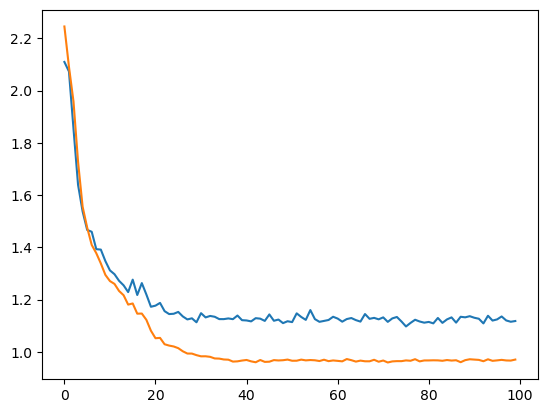

In [15]:
plt.plot(train_state["val_loss"])
plt.plot(train_state["train_loss"])

# Testing

In [16]:
classifier.load_state_dict(torch.load(args.model_filename))

classifier = classifier.to(args.device)
loss_func = torch.nn.CrossEntropyLoss(1 / torch.log(dataset.frequency_y()))

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size)

running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, (x, y) in enumerate(batch_generator):
    y_hat =  classifier(x)
    
    # compute the loss
    loss = loss_func(y_hat, y)
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_hat, y)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print(f"Test loss: {running_loss:.4f}")
print(f"Test Accuracy: {running_acc:.4f}")

Test loss: 1.5613
Test Accuracy: 64.2909


### Inference

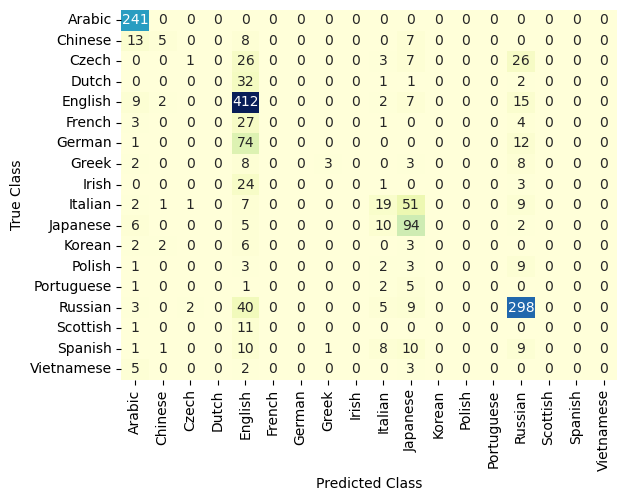

In [17]:
dataset.set_split('test')

x, y = next(generate_batches(dataset, len(dataset)))
y_hat = classifier(x, apply_softmax=True).argmax(dim=1)

labels = list(dataset.vectorizer_y.vocab.ordered_tokens())

conf_df = pd.DataFrame(confusion_matrix(y, y_hat), index=labels, columns=labels)

sns.heatmap(conf_df, annot=True, cbar=None, cmap="YlGnBu", fmt="d")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [18]:
def predict(model, vectorizer_x, vectorizer_y, surname):
    x = vectorizer_x.vectorize(surname)
    y_hat = model(x.unsqueeze(dim=0), apply_softmax=True)
    return vectorizer_y.vocab[y_hat.argmax().item()]    

predict(classifier, surname_vectorizer, nationality_vectorizer, "Johnson")

'English'

# Misc

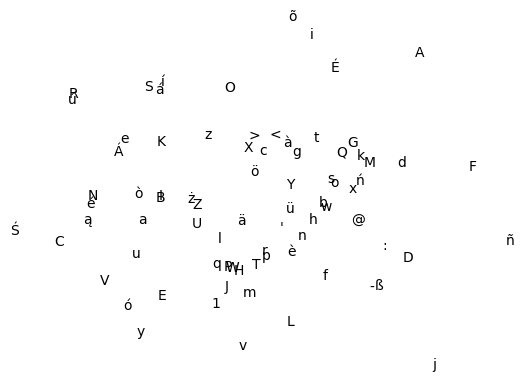

In [75]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

emb = classifier.emb.weight.data[1:,:]
labels = list(surname_vocab.ordered_tokens())[1:]
x = torch.tensor(pca.fit_transform(emb))


plt.axis("off")
plt.axis([torch.min(x).item(), torch.max(x).item(), torch.min(x).item(), torch.max(x).item()])
for (xi, yi), lbl in zip(x, labels):
    plt.text(xi, yi, lbl)